<a href="https://colab.research.google.com/github/jp-ishimwe/Projects/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip3 install transformers --upgrade
#!pip install transformers -q
#!pip install wandb -q
!pip3 install --upgrade wandb
!pip3 install dill -q

In [6]:
#@title Import packages { run: "auto", vertical-output: true, display-mode: "both" }
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pickle
import dill
import tarfile
import json, gzip
import math
from typing import Optional, Union
import os

import wandb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
#!cp '/root/optimizers.py' '/root/Projects/' # SSH
#!cp '/home/jupyter/optimizers.py' '/home/jupyter/Projects/' # for GCP
#!cp '/content/drive/My Drive/Colab Notebooks/optimizers.py' .


from optimizers import AdaFactor

In [5]:
!nvidia-smi
!/usr/local/cuda/bin/nvcc --version

Thu Jul 23 12:50:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    27W / 149W |     11MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
#@title To proceed should be cuda { run: "auto", vertical-output: true }
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
print(device)

cuda


In [4]:
##!wandb login fac9119080ca108ca15c420ede645a5e6e79a07c

### First Log in 

In [5]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'Final_Project.ipynb'

#### Getting dataset

You can find the dataset [here](http://lil.nlp.cornell.edu/newsroom/download/index.html)

**Loading data**

In [ ]:
# fname = '/content/drive/My Drive/Colab Notebooks/newsroom-release.tar'

# tar = tarfile.open(fname, "r:")
# tar.extractall()
# tar.close()

In [ ]:
#!mv '/content/data/' '/content/drive/My Drive/Colab Notebooks'

In [ ]:
#!cp -r '/content/release/' '/content/drive/My Drive/Colab Notebooks/data'

In [4]:
#path = '/home/jupyter/' # GCp
path = '/root/release/' # SSH
#path = "/content/drive/My Drive/Colab Notebooks/data/release/" # Colab

def read_data(path, name):
  data = []
  with gzip.open(path + name + ".jsonl.gz") as f: #+".jsonl.gz" with GCP
      for ln in f:
          obj = json.loads(ln)
          data.append(obj)
  return data

trainset = read_data(path, 'train') 
devset = read_data(path, 'dev')
#testset = read_data(path, 'test')

In [5]:
def get_data(data):
  data_dict = {'text': [], 'summary': []}
  for article in data:
    data_dict['text'].append(article['text'])
    data_dict['summary'].append(article['summary'])
  return pd.DataFrame(data_dict)

train_data = get_data(trainset)
valid_data = get_data(devset)
# test_data = get_data(testset)

In [9]:
train_data.head()

,text,summary
0,"HAMBURG, Germany, June 3  As he left the socc...",A surge in discriminatory behavior toward blac...
1,"WASHINGTON, Dec. 23 - The National Security Ag...","The volume of information harvested, without \..."
2,IF outsized executive pay has indeed become a ...,The battle between Pfizer Inc.'s investors and...
3,BY A.J. BENZA & MICHAEL LEWITTES\n\nIf Simon R...,"If Simon Rex looks a little familiar, it may n..."
4,Spinach has terrorized generations of veggie-p...,POPEYE-WORTHY PIE. PHYLLO DOUGH WRAPS SPINACH ...


In [10]:
print(f'The size of training dataset:{train_data.shape} | validation dataset: {valid_data.shape}')

The size of training dataset:(995041, 2) | validation dataset: (108837, 2)


In [6]:
contraction = {"isn't": "is not", "aren't": "are not","can't": "cannot", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you ll":"you will", "you'll've": "you will have",
                           "you're": "you are", "you re": "you are" , "you've": "you have"}

###### Checking for NA

In [12]:
train_data.isna().sum(), valid_data.isna().sum()

(text       0
 summary    0
 dtype: int64, text       0
 summary    0
 dtype: int64)

##### Preprocessing

In [7]:
class TextProccessing(BaseEstimator, TransformerMixin):
  def __init__(self, column, contraction):
    self.column = column
    self.contraction = contraction
  def fit(self, x, y=None):
    return self
  @staticmethod
  def preprocessing(line):
    date_pattern = r'(0?[1-9]/|1[0-2]/)(0?[1-9]/|[1-2][0-9]/|3[0-1]/)[0-9]{4}'
    line = line.split("\n")
    clean_line = []
    for l in line:
        if re.match(date_pattern, l) is not None:
            pass
        else:
            clean_line.append(l)
    line = "\n".join(clean_line)

    line = re.sub(r"http\S+", " ",line)
    line = re.sub(r"www\S+", " ",line)
    line = line.replace('—', ' ')
    line = line.replace('-', ' ')
    line = line.replace('&', 'and')
    line = line.replace('[...]', '')
    line = line.replace('...', '.')
    line = line.replace('…', ' ')
    line = re.sub(re.compile('<.*?>'), '', line)
    line = re.sub(re.compile('@\S+'), r'', line)
    line = re.sub(r'#\S+ ', r'', line)
    line = line.replace("â", "'") 
    line = line.replace('--', ' ')
    line = re.sub(r'[^\sa-zA-Z0-9.,!?]',' ',line)
    line = line.strip()
    line = line.replace("\xa0", "")
    line = line.replace("click to share on twitter", "")

    line = re.sub(r'[ \t]{2,}',' ', line)
    return line

  def transform(self, X):
    #X = X[self.column].replace(self.contraction)
    return X[self.column].replace(self.contraction).fillna('').apply(lambda x: self.preprocessing(x)) 

In [8]:
class Processor:

  def __init__(self, data, 
               contraction,
               max_length = None):
    
    self.max_length = max_length
    self.data = data
    self.contraction = contraction

    
  def cleaning(self, data):
    if not isinstance(data, pd.DataFrame):
      raise TypeError('Only Dataframes are allowed, but got data={}'.format(data))
    else:
      print('Please wait, we are cleaning...')
      titles = ['text', 'summary']
      data_dict = {}

      for title in titles:
        proc = TextProccessing(title, self.contraction)
        res = proc.fit_transform(data)
        data_dict[title] = res

      ss = pd.DataFrame(data_dict)
      
      return ss

  @staticmethod
  def split(data):
    return len(data.split())

  def get_max_tokens(self, dataframe):

    dataframe['article_len'] = dataframe['text'].apply(self.split)
    dataframe['summary_len'] = dataframe['summary'].apply(self.split)
    
    max_len = {'max_article_tokens': max(dataframe['article_len']), 
                'min_article_tokens': min(dataframe['article_len']),
                'max_summary_tokens': max(dataframe['summary_len']),
                'min_summary_tokens': min(dataframe['summary_len'])}
    return max_len, dataframe

  def cleaned_data(self):
    dataframe = self.cleaning(self.data)
    
    if self.max_length is None:
      min_len, dataframe = self.get_max_tokens(dataframe)
    else:
      min_len = self.max_length

    min_length = min_len['min_article_tokens']
    idx_list = []
    for idx, paragraph in tqdm(enumerate(dataframe['text'])):
        pragraph = len(paragraph.split())
        if pragraph < min_length:
          idx_list.append(idx)
    final_data = dataframe.drop(idx_list)
    final_data = final_data.reset_index(drop=True)

    max_len, final_data = self.get_max_tokens(final_data)

    print('Done!')
    
    return final_data, max_len

In [9]:
maxlen = {'max_article_tokens': 512,
          'max_summary_tokens': 300,
          'min_article_tokens': 100,
          'min_summary_tokens': 0}

In [10]:
textproc = Processor(train_data, contraction, maxlen)
train_processed, doc_lengths = textproc.cleaned_data()

Please wait, we are cleaning...


995041it [00:31, 31844.18it/s]


Done!


In [12]:
train_processed.to_pickle("./train_processed.pkl")

In [9]:
train_processed = pd.read_pickle("./train_processed.pkl")

In [13]:
textproc = Processor(valid_data, contraction, maxlen)
valid_processed, valid_doc_lengths = textproc.cleaned_data()

Please wait, we are cleaning...


108837it [00:03, 32442.50it/s]


Done!


In [14]:
valid_processed.to_pickle("./valid_processed.pkl")

In [10]:
valid_processed = pd.read_pickle("./valid_processed.pkl")

In [11]:
train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951381 entries, 0 to 951380
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         951381 non-null  object
 1   summary      951381 non-null  object
 2   article_len  951381 non-null  int64 
 3   summary_len  951381 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 29.0+ MB


Only one article droped that was having zeros length. However we still have some article with no summaries. Therefore we can get rid off them.

In [28]:
doc_lengths

In [12]:
indices = np.where(train_processed['summary_len'] < 10)
train_processed_data = train_processed.drop(indices[0])
train_processed_data = train_processed_data.reset_index(drop=True)
#train_processed.iloc[indices[0]]

In [10]:
#train_data.iloc[954753]['summary'] # '<ul>\n\t<li><b>£', 'Ø¨Ø§ Ø§Û\x8cÙ\x86 Ø§Ø\xadØ³Ø§Ø³ Ø¯Ø±Ù\x85Ø§Ù\x86Ø¯Ú¯Û\x8cØ\x8c Ø¨Ù\x87 Ù\x86Ø¸Ø±Øª Ù\x85Û\x8câ\x80\x8fØ±Ø³Ø¯ Ú©Ù\x87 ØªØ\xadØ±Û\x8cÙ\x85â\x80\x8fÙ\x87Ø§ Ø¯Ø§Ø±Ù\x86Ø¯ Ú©Ø§Ø± Ù\x85Û\x8câ\x80\x8fÚ©Ù\x86Ù\x86Ø¯'

In [11]:
train_processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882676 entries, 0 to 882675
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         882676 non-null  object
 1   summary      882676 non-null  object
 2   article_len  882676 non-null  int64 
 3   summary_len  882676 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 26.9+ MB


In [12]:
train_processed_data['summary_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000     24.0
0.7500     31.0
0.9000     44.0
0.9500     58.0
0.9900    141.0
0.9990    343.0
0.9999    663.0
Name: summary_len, dtype: float64

In [34]:
train_processed_data['article_len'].quantile([0.1,0.25,0.4,0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.1000      192.000
0.2500      322.000
0.4000      465.000
0.5000      574.000
0.7500      890.000
0.9000     1237.000
0.9500     1575.000
0.9900     3206.250
0.9990     8660.600
0.9999    23091.975
Name: article_len, dtype: float64

In [35]:
valid_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104147 entries, 0 to 104146
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         104147 non-null  object
 1   summary      104147 non-null  object
 2   article_len  104147 non-null  int64 
 3   summary_len  104147 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.2+ MB


In [37]:
valid_doc_lengths

In [13]:
inds = np.where(valid_processed['summary_len'] < 10)
#valid_processed.iloc[inds[0]]
valid_processed_data = valid_processed.drop(inds[0])
valid_processed_data = valid_processed_data.reset_index(drop=True)

In [14]:
valid_processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96581 entries, 0 to 96580
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         96581 non-null  object
 1   summary      96581 non-null  object
 2   article_len  96581 non-null  int64 
 3   summary_len  96581 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


In [6]:
valid_processed_data['article_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000      571.000
0.7500      885.000
0.9000     1228.000
0.9500     1568.000
0.9900     3119.600
0.9990     8641.460
0.9999    22122.936
Name: article_len, dtype: float64

In [7]:
valid_processed_data['summary_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000     24.000
0.7500     31.000
0.9000     45.000
0.9500     60.000
0.9900    146.000
0.9990    364.000
0.9999    724.234
Name: summary_len, dtype: float64

In [15]:
art = 512 #int(train_processed_data['article_len'].quantile(0.9900))
sum_ = 150# int(train_processed_data['summary_len'].quantile(0.9900))

print(f'art len:{art}, sum len:{sum_}')

art len:512, sum len:150


In [16]:
artV = 512 #int(valid_processed_data['article_len'].quantile(0.9900))
sumV = 150# int(valid_processed_data['summary_len'].quantile(0.9900))

print(f'art len:{artV}, sum len:{sumV}')

art len:512, sum len:150


#### Creating Custom Dataset

In [17]:
class CustomDataReader(Dataset):
  """
  Loading data to be used in pytorch pre-trained models
  
  """
  def __init__(self, dataframe, T5tokenizer, max_article_tokens=None,max_summary_tokens=None ):
    self.tokenizer = T5tokenizer
    self.dataframe = dataframe
    self.eos = ' </s>'  #tokenizer.eos_token
    self.sos = '<pad> ' #tokenizer.pad_token
    self.source_len = max_article_tokens
    self.target_len = max_summary_tokens
  
  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    articles = "summarize: " + self.dataframe.text[idx] + self.eos
    articles = ' '.join(articles.split())

    summary = self.sos + self.dataframe.summary[idx] + self.eos
    summary = ' '.join(summary.split())

    source_tokenized = self.tokenizer.batch_encode_plus([articles], max_length= self.source_len, pad_to_max_length=True, truncation=True,return_tensors='pt')
    target_tokenized = self.tokenizer.batch_encode_plus([summary], max_length= self.target_len, pad_to_max_length=True, truncation=True,return_tensors='pt')

    source_ids = source_tokenized['input_ids'].squeeze(0)
    source_mask = source_tokenized['attention_mask'].squeeze(0)

    summary_ids = target_tokenized['input_ids'].squeeze(0)
    summary_mask = target_tokenized['attention_mask'].squeeze(0)

    return source_ids, source_mask, summary_ids, summary_mask


In [18]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

#### Training Loop

In [38]:
def training(model, dataset_loader, optimizer,log_interval,eps_sched, batchs, regularizer,iteration=0):

    model.train()
    avg_loss = 0
    nItem = 0


    print(f'Start training for epoch: {iteration}')
    losses = AverageMeter()
    tqdok = tqdm(dataset_loader, total=len(dataset_loader))
 
    for idx, data_train in enumerate(tqdok):

        input_ids, source_mask, summary_ids, summary_mask = data_train

        input_ids = input_ids.to(device, dtype = torch.long)
        source_mask = source_mask.to(device, dtype = torch.float)
        summary_ids = summary_ids.to(device, dtype = torch.long)

        target_labels = summary_ids[:, :-1].contiguous()
        langm_labels = summary_ids[:, 1:].clone().detach()
        langm_labels[summary_ids[:, 1:] == tokenizer.pad_token_id] = -100

        optimizer.zero_grad()

        output = model(input_ids=input_ids, attention_mask = source_mask, decoder_input_ids=target_labels, lm_labels=langm_labels, lamda=regularizer)

        loss = output[0]

        loss.backward()
        optimizer.step()

        bs = input_ids.size(0)
        nItem += bs        
        
        itr = iteration*(len(dataset_loader.dataset)//batchs) + idx
        optimizer.param_groups[0]['eps'] = eps_sched[itr]

        avg_loss += loss.item() * bs

        if idx%log_interval == 0:
                wandb.log({"Training Loss": loss.item()})
#         if idx % 5000 == 0:
#           print(f'[{idx * len(input_ids)}/{len(dataset_loader.dataset)} ({100. * idx / len(dataset_loader):.0f})%] \t Training loss: {loss:.3f}')
        
        losses.update(loss.item(), bs)
        tqdok.set_postfix(loss=losses.avg)
        
    avg_loss /= nItem
  
    return avg_loss, output


In [20]:
def validation(model, dataset_loader, regularizer):
    model.eval()

    eval_loss = 0
    nItem = 0

    losses = AverageMeter()
    tqdok = tqdm(dataset_loader, total=len(dataset_loader))

    with torch.no_grad():
        for idx, data_val in enumerate(tqdok):
            input_ids, source_mask, summary_ids, summary_mask = data_val

            input_ids = input_ids.to(device, dtype = torch.long)
            source_mask = source_mask.to(device, dtype = torch.float)
            summary_ids = summary_ids.to(device, dtype = torch.long)

            target_labels = summary_ids[:, :-1].contiguous()
            langm_labels = summary_ids[:, 1:].clone().detach()
            langm_labels[summary_ids[:, 1:] == tokenizer.pad_token_id] = -100

            output = model(input_ids=input_ids, attention_mask = source_mask, decoder_input_ids=target_labels, lm_labels=langm_labels, lamda=regularizer)

            loss = output[0]

            bs = input_ids.size(0)
            nItem += bs

            eval_loss += loss.item()

            losses.update(loss.item(), bs)
            tqdok.set_postfix(loss=losses.avg)

    eval_loss /= nItem

    return eval_loss

In [21]:
def saving(PATH, epoch, avg_loss, model,pp, LEARNING_RATE):
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'train_loss': avg_loss,
            'perplexity': pp,
            'learning_rate': LEARNING_RATE
            }, PATH)

#### The model evaluation

The perplexity:

\begin{align}
\large \text{ppl}(p, D) &\large = 2^{-\frac{1}{N_{total}}\log_2 p(D)}
\end{align}

where $D=\{(w_1,\ldots,w_{N_i})_i\}_{i=1}^M$ is a dataset of $M$ sequences with total length $N_{\text{total}}=\sum_{i}N_i$.


#### Computing perplexity

Our model's loss is the (negative) log probability of every token in the output sequence, which can be used to compute perplexity.

We define perplexity using the **base 2** logarithm.

In [22]:
def get_perplexity(epoc_loss):
  rs = epoc_loss/np.log(2)
  pp = 2**rs
  return pp

In [26]:
#@title #### Loading T5 model and its Tokenizer { run: "auto" }

LEARNING_RATE = 3.55e-4
MODEL_NAME = 't5-base' # or T5-Large:770 params, T5-3B, T5-Base: 220 Params, T5-11B
t5model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
#optimizer = optim.Adam(t5model.parameters(), lr=LEARNING_RATE)

In [27]:
class GatedFilterLayer(nn.Module):
  r"""
  Receives the keys from the encoder output.

  Returns:
    Output the values between [0,1]
   """

  def __init__(self, hidden_size_model):
    super(GatedFilterLayer, self).__init__()

    self.hidden_size_model = hidden_size_model
    self.projector = nn.Linear(hidden_size_model, 1, bias=False)

#     self.init_weights()

#   def init_weights(self):
#     initrange = 0.1
#     self.projector.bias.data.zero_()
#     self.projector.weight.data.uniform_(-initrange, initrange)

  def forward(self, last_hidden_encoder):
    proj = self.projector(last_hidden_encoder)
    gate = torch.sigmoid(proj)
    hidden_encoder = gate * last_hidden_encoder
    return hidden_encoder, gate

In [28]:
class EncoderModule(nn.Module):

  def __init__(self, T5ForGmodel=None, model_name = 't5-base'):
    super(EncoderModule, self).__init__()

    if T5ForGmodel is None:

      MODEL_NAME = model_name 
      if MODEL_NAME not in ['t5-base','t5-small','t5-large','t5-3b','t5-11b']:
        raise NameError('Name {} is not specified in T5 model names'.format(MODEL_NAME))

      T5model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
      self.encoder_model = T5model.encoder
      dmodel = T5model.config.d_model
    else:
      self.encoder_model = T5ForGmodel.encoder
      dmodel = T5ForGmodel.config.d_model

    self.gatefilter = GatedFilterLayer(dmodel)


  def forward(self, input_ids=None, attention_mask=None, inputs_embeds=None, head_mask=None, output_hidden_states=False):
    
    if input_ids is None and inputs_embeds is None:
      raise ValueError("You have to specify either input_ids or input_embeds")
    
    if self.encoder_model.config.output_hidden_states or output_hidden_states:
      encoder_out =  self.encoder_model(input_ids=input_ids, 
                                      attention_mask=attention_mask,
                                      inputs_embeds=inputs_embeds,
                                      head_mask=head_mask,
                                      output_hidden_states=True)
    else:
      encoder_out =  self.encoder_model(input_ids=input_ids, 
                                      attention_mask=attention_mask,
                                      inputs_embeds=inputs_embeds,
                                      head_mask=head_mask)
    lst_enc_hidden = encoder_out[0]
    last_hidden_out, gate = self.gatefilter(lst_enc_hidden)

    last_hidden_out = (last_hidden_out, ) + encoder_out[1:] + (gate,)

    return last_hidden_out

In [29]:
class GatedT5ForSummurization(nn.Module):
  
  """
  Gated T5 with Language Model
  
  """

  def __init__(self,t5model=None, MODEL_NAME='t5-base'):
    super(GatedT5ForSummurization, self).__init__()

    self.encoder = EncoderModule(T5ForGmodel=t5model, model_name=MODEL_NAME)
    
    if t5model is None:
        self.decoder = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
    else:
        self.decoder = t5model

  def forward(self,input_ids=None, attention_mask=None,
              decoder_input_ids=None,decoder_attention_mask=None,
              decoder_past_key_value_states=None,use_cache=True,lm_labels=None,
              inputs_embeds=None,decoder_inputs_embeds=None, head_mask=None,
              output_hidden_states=False,lamda = 0.0,
             ):

    encoder_outputs = self.encoder(input_ids=input_ids, 
                                   attention_mask=attention_mask,
                                   inputs_embeds=inputs_embeds, 
                                   head_mask=head_mask,
                                   output_hidden_states=output_hidden_states)

    decoder_outputs = self.decoder(
            encoder_outputs=encoder_outputs,
            decoder_input_ids = decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            decoder_past_key_value_states = decoder_past_key_value_states,
            use_cache=use_cache,
            lm_labels = lm_labels,
            decoder_inputs_embeds=decoder_inputs_embeds,
            head_mask=head_mask)
        
    # Computing MLE Loss + L1 Norm Reg on LN weight
    if lm_labels is not None:

      Loss_MLE = decoder_outputs[0]
      #weight = self.encoder.gatefilter.projector.weight
      gate = encoder_outputs[-1]
      Loss_gate = torch.sum(gate.squeeze(-1))/(gate.shape[0]*gate.shape[1]) * lamda
      Loss = Loss_MLE + Loss_gate
    
      decoder_outputs = (Loss,) + decoder_outputs[1:]
      
    return decoder_outputs

  def generate(self,
               input_ids = None, max_length = None, min_length = None,do_sample = None,
        early_stopping = None,num_beams = None,temperature= None,top_k: Optional[int] = None,
        top_p: Optional[float] = None, repetition_penalty = None,bad_words_ids = None,
        bos_token_id  = None, pad_token_id  = None,eos_token_id = None,length_penalty= None,
        no_repeat_ngram_size = None,num_return_sequences = None,attention_mask = None,
        decoder_start_token_id = None,use_cache: Optional[bool] = None):

    """
    All possible inputs receive by the generator
    For more details look @ huggingface documentation
    
        input_ids = None, max_length = None, min_length = None,do_sample = None,
        early_stopping = None,num_beams = None,temperature= None,top_k: Optional[int] = None,
        top_p: Optional[float] = None, repetition_penalty = None,bad_words_ids = None,
        bos_token_id  = None, pad_token_id  = None,eos_token_id = None,length_penalty= None,
        no_repeat_ngram_size = None,num_return_sequences = None,attention_mask = None,
        decoder_start_token_id = None,use_cache: Optional[bool] = None
    """

    return self.decoder.generate(input_ids = input_ids, max_length = max_length, min_length = min_length,do_sample = do_sample,
        early_stopping = early_stopping,num_beams = num_beams,temperature= temperature,top_k = top_k,
        top_p = top_p, repetition_penalty = repetition_penalty,bad_words_ids = bad_words_ids,
        bos_token_id  = bos_token_id, pad_token_id  = pad_token_id,eos_token_id = eos_token_id,length_penalty= length_penalty,
        no_repeat_ngram_size = no_repeat_ngram_size,num_return_sequences = num_return_sequences,attention_mask = attention_mask,
        decoder_start_token_id = decoder_start_token_id,use_cache = use_cache
    )

In [30]:
model = GatedT5ForSummurization(t5model=t5model)


In [47]:
eos = tokenizer.eos_token
sos = tokenizer.pad_token
eos, sos

('</s>', '<pad>')

In [31]:
#@title Train, Validation and Test splits { run: "auto" }

columns = ["text","summary"]

X_train = train_processed_data[columns] #X_train.reset_index(drop=True)
X_valid = valid_processed_data[columns] #X_val.reset_index(drop=True)

In [32]:
X_train.head()

,text,summary
0,"HAMBURG, Germany, June 3 As he left the soccer...",A surge in discriminatory behavior toward blac...
1,"WASHINGTON, Dec. 23 The National Security Agen...","The volume of information harvested, without \..."
2,IF outsized executive pay has indeed become a ...,The battle between Pfizer Inc. s investors and...
3,BY A.J. BENZA and MICHAEL LEWITTES\n\nIf Simon...,"If Simon Rex looks a little familiar, it may n..."
4,Spinach has terrorized generations of veggie p...,POPEYE WORTHY PIE. PHYLLO DOUGH WRAPS SPINACH ...


In [33]:
def get_dataloader(X, BATCH_SIZE,valid=None, **kwargs):

    if valid == 'valid':
        val_params = {
            'batch_size': BATCH_SIZE,
            'shuffle': False,
            'num_workers': 2
            }
        data_set = CustomDataReader(X, tokenizer,**kwargs)
        data_loader = DataLoader(data_set, **val_params)
        
    else:
        data_set = CustomDataReader(X, tokenizer,**kwargs)     
        train_params = {
            'batch_size': BATCH_SIZE,
            'shuffle': True,
            'num_workers': 2
            }
        data_loader = DataLoader(data_set, **train_params)
    
    return data_loader

In [44]:
Xtrain_trial = X_train.iloc[:50000]
Xvalid_trial = X_valid.iloc[:3600]

In [36]:
indices = np.random.permutation(len(X_train))
valind = np.random.permutation(len(X_valid))

ind = indices[:70000]
vind = valind[:5000]

Xtrain_trial = X_train.iloc[ind]
Xvalid_trial = X_valid.iloc[vind]

Xtrain_trial = Xtrain_trial.reset_index(drop=True)
Xvalid_trial = Xvalid_trial.reset_index(drop=True)

In [25]:
N_EPOCHS = 2
path = '/content/drive/My Drive/Colab Notebooks/best_model.pth'
pcle = '/content/drive/My Drive/Colab Notebooks/optimizer_state_dict.pkl'
#filename = open(pcle, 'wb')

In [39]:
def run(model,
        X_train, X_valid, 
        path=None,filename=None,
        lr= LEARNING_RATE):

    #best_loss = float('inf')
    #best_pp = float('inf')
    # WandB – Initialize a new run
    
    wandb.init(entity="jp-ishimwe", project="test-summaries") 
#     wandb.init(entity="jp-ishimwe", project="document-summarization-test")
    #wandb.init(entity="jp-ishimwe", project="document-summarization-using-transformer")
#     wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release

    # WandB – Config is a variable that holds and saves hyperparameters and inputs
    # Defining some key variables that will be used later on in the training  
    config = wandb.config          
    config.BATCH_SIZE = 8
    config.EVAL_BATCH_SIZE = 10
    config.N_EPOCHS = 3 
    config.LEARNING_RATE = lr
    config.SEED = 42               
    config.art_maxlen = art
    config.summary_maxlen = sum_
    config.Valid_art_maxlen = artV
    config.Valid_summary_maxlen = sumV
    config.log_interval = 500     # how many batches to wait before logging training status
    config.reg = 0.3092

    random.seed(config.SEED)
    np.random.seed(config.SEED)
    torch.manual_seed(config.SEED)
    torch.backends.cudnn.deterministic = True
    
    kwargs = {'max_article_tokens': config.art_maxlen,
                'max_summary_tokens': config.summary_maxlen
             }
    
    kwargsval = {'max_article_tokens': config.Valid_art_maxlen,
                'max_summary_tokens': config.Valid_summary_maxlen
             }
    
    
    train_loader = get_dataloader(X_train, config.BATCH_SIZE,valid=None, **kwargs)
    val_loader  = get_dataloader(X_valid, config.EVAL_BATCH_SIZE,valid='valid', **kwargsval)
    
    train_loss = []
    val_loss = []
    perplexity = []
    
    model = model.to(device)
    params = {'params': model.parameters()}
    optimizer = optim.Adam([params], lr=config.LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=0)
    
    wandb.watch(model, log="all")
    wandb.unwatch(model) 

    maxiter = config.N_EPOCHS*(len(train_loader.dataset)//config.BATCH_SIZE)
    eps_sched = 1e-8 + 0.5-0.5*np.cos(np.linspace(0, np.pi, maxiter))

    for epoch in range(config.N_EPOCHS):

        avg_loss, outputs = training(model, train_loader, optimizer, config.log_interval,eps_sched, config.BATCH_SIZE, regularizer=config.reg, iteration=epoch)
        print('\nValidation start:')
        eval_loss = validation(model, val_loader, regularizer=config.reg)

        pp = get_perplexity(eval_loss)

        perplexity.append(pp)
        train_loss.append(avg_loss)
        val_loss.append(eval_loss)
        scheduler.step(eval_loss)


        print(f'Epoch loss: {avg_loss:.4f}')
        print(f'Perplexity: {pp:.4f} | Eval loss: {eval_loss:.4f}')
        print("--------------")


        wandb.log({
            "Training Loss": avg_loss,
            "Perplexity ": pp,
            "Eval Loss": eval_loss})


        # Save model to wandb
#         torch.save(model.state_dict(), os.path.join(wandb.run.dir, 'model0.pt'))
        torch.save(model.state_dict(), '/root/Projects/model2.pt')


    return train_loss, perplexity, val_loss, outputs


    #     if pp < best_pp:
    #       best_pp = pp
    #       saving(path, epoch, avg_loss, model, pp, lr)
    #       dill.dump(optimizer, filename)

    # Save model for every 3 epochs
    # if i%3==0:
    #   torch.save(model.state_dict(), path)
    #print(f'Best Perplexity: {best_pp}')
    #filename.close()

In [40]:
train_loss, perplexity, eval_loss, outputs = run(model, Xtrain_trial, Xvalid_trial,lr= LEARNING_RATE)

  0%|          | 0/8750 [00:00<?, ?it/s]

Start training for epoch: 0


  0%|          | 0/500 [00:00<?, ?it/s]


Validation start:


100%|██████████| 500/500 [02:35<00:00,  3.22it/s, loss=1.64]


Epoch loss: 1.7816
Perplexity: 1.1777 | Eval loss: 0.1636
--------------


  0%|          | 0/8750 [00:00<?, ?it/s]

Start training for epoch: 1


  0%|          | 0/500 [00:00<?, ?it/s]


Validation start:


100%|██████████| 500/500 [02:35<00:00,  3.22it/s, loss=1.63]


Epoch loss: 1.7350
Perplexity: 1.1769 | Eval loss: 0.1629
--------------


  0%|          | 0/8750 [00:00<?, ?it/s]

Start training for epoch: 2


  0%|          | 0/500 [00:00<?, ?it/s]


Validation start:


100%|██████████| 500/500 [02:35<00:00,  3.21it/s, loss=1.63]


Epoch loss: 1.7300
Perplexity: 1.1767 | Eval loss: 0.1627
--------------


Evaluating the gate distributions

In [41]:
outputs[-1].shape

torch.Size([8, 512, 1])

In [42]:
gates = outputs[-1].squeeze(-1) 

In [43]:
gates.mean(dim=1,keepdim=True)

tensor([[0.4434],
        [0.4514],
        [0.4564],
        [0.3715],
        [0.3544],
        [0.4491],
        [0.4423],
        [0.4473]], device='cuda:0', grad_fn=<MeanBackward1>)

In [44]:
values, _ = gates.max(dim=1,keepdim=True)
values

tensor([[0.6062],
        [0.5945],
        [0.6242],
        [0.6004],
        [0.6228],
        [0.6031],
        [0.6121],
        [0.6181]], device='cuda:0', grad_fn=<MaxBackward0>)

In [45]:
vals, _ = gates.min(dim=1,keepdim=True)
vals

tensor([[0.2839],
        [0.3008],
        [0.2923],
        [0.1030],
        [0.0873],
        [0.2654],
        [0.2683],
        [0.2925]], device='cuda:0', grad_fn=<MinBackward0>)

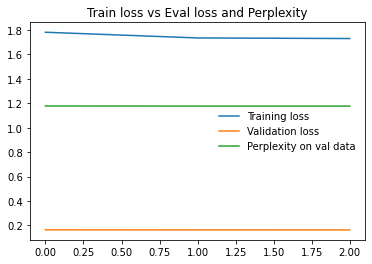

In [46]:
import matplotlib.pyplot as plt

tr_los = np.array(train_loss)
ev_los = np.array(eval_loss)
per = np.array(perplexity)

plt.plot(tr_los, label='Training loss')
plt.plot(ev_los, label='Validation loss')
plt.plot(per, label='Perplexity on val data')

plt.legend(frameon=False)
plt.title('Train loss vs Eval loss and Perplexity')
plt.show()

In [85]:
def generator(model, dataset_loader):
  
  model.eval()

  results = {"generated_summary": [], "golden_summary": []}

  with torch.no_grad():

    for idx, data_val in enumerate(dataset_loader):
      
      input_ids, source_mask, summary_ids, summary_mask = data_val 
      
      input_ids = input_ids.to(device, dtype = torch.long)
      source_mask = source_mask.to(device, dtype = torch.float)
      summary_ids = summary_ids.to(device, dtype = torch.long)

      generatation = model.generate(input_ids=input_ids,
                                    attention_mask=source_mask, 
                                    min_length=30, 
                                    max_length=300, 
                                    num_beams=4,
                                    repetition_penalty=2.5,
                                    eos_token_id = model.decoder.config.eos_token_id,               
                                    length_penalty=1.0, 
                                    early_stopping=True
                                    )

      for gen, sc in zip(generatation, summary_ids): # Taking whole document IDs and docode the summary

        gen_tokens_dec = tokenizer.decode(gen, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        sc_tokens_dec = tokenizer.decode(sc, skip_special_tokens=True, clean_up_tokenization_spaces=True)

        results["generated_summary"].append(gen_tokens_dec)
        results["golden_summary"].append(sc_tokens_dec)

  return results


#### Loading Saved Model

In [ ]:
pretrained = False

if pretrained:    

    model = .... # first initialize the model and optimizer

    #optimizer = ... # optimizer then,
    infile = open(pcle,'rb')
    optimizer = pickle.load(infile)
    infile.close()

    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

In [61]:
!ls /root/Projects


Final_Project.ipynb	     Wheat_rust_classification.ipynb
README.md		     model.pt
T5_ftransfer_learning.ipynb  valid_processed.pkl
Untitled.ipynb		     wandb


In [22]:
model.load_state_dict(torch.load('/root/Projectsmodel0.pt'))
model = model.to(device)

In [23]:
#model = torch.load('/root/Projects/model.pt')

In [48]:
ivind = valind[5000:6000]

X_trial = X_valid.iloc[ivind]

Xtest_trial = X_trial.reset_index(drop=True)

argsval = {'max_article_tokens': 512,
                'max_summary_tokens': 150
             }
    
    
val_loader  = get_dataloader(Xtest_trial, 6,valid='valid', **argsval)

In [86]:
%time results = generator(model, val_loader)

CPU times: user 40min 7s, sys: 2min 35s, total: 42min 43s
Wall time: 38min 43s


In [75]:
 #input_ids, source_mask, summary_ids, summary_mask = next(iter(val_loader))

#### Visualizing examples

**Example 1**

In [89]:
Xtest_trial.iloc[0,:]['text']

'Culture Connoisseurs consistently offer thought provoking, timely comments on the arts, lifestyle and entertainment.\n\nMore about badges Request a badge\n\nWashingtologists consistently post thought provoking, timely comments on events, communities, and trends in the Washington area.\n\nMore about badges Request a badge\n\nThis commenter is a Washington Post editor, reporter or producer.\n\nThis commenter is a Washington Post contributor. Post contributors aren t staff, but may write articles or columns. In some cases, contributors are sources or experts quoted in a story.\n\nMore about badges Request a badge\n\nWashington Post reporters or editors recommend this comment or reader post.\n\nYou must be logged in to report a comment.\n\nYou must be logged in to recommend a comment.'

In [90]:
print("Actual summary:")
results['golden_summary'][0]

Actual summary:


'In a Telemundo interview, Mitt Romney denies problems in his campaign.'

In [91]:
print('Generated summary:')
results['generated_summary'][0]

Generated summary:


'You must be logged in to report a comment. You must be logged in to report a comment. You must be logged in to recommend a comment.'

**Example 2**

In [92]:
Xtest_trial.iloc[1,:]['text']

'When Hockey Canada needed a coach for its women s hockey team less than two months before the Sochi Olympics, Kevin Dineen stepped up. Not long after he won gold, the phone rang again for a job leading the under 18 men s team.\n\n One call to him at the under 18 level, he just said yes right away, Hockey Canada s Scott Salmond said.\n\nOn Monday, Dineen began the next chapter of his coaching career as he was named as an assistant on Joel Quenneville s staff with the Chicago Blackhawks.\n\nSo excited about the opportunity to work with this group of people. World class players and organization. pic.twitter.com 4PDM2GJLvk\n\n He doesn t care if he s coaching women or men or kids or what it is. He s a coach, and that s what he loves to do, Salmond said in a phone interview. To me, great coaches like challenges and they want to coach, they want to be busy, they want to work and Kevin s a great example of that. It wasn t a surprise to me that someone in an organization like Chicago would re

In [93]:
print("Actual summary:")
results['golden_summary'][1]

Actual summary:


'Kevin Dineen, who coached Canada s women s hockey team to a gold medal at the Sochi Olympics, has returned to the NHL as an assistant with the Chicago Blackhawks.'

In [94]:
print('Generated summary:')
results['generated_summary'][1]

Generated summary:


'When Hockey Canada needed a coach for its women s hockey team less than two months before the Sochi Olympics, Kevin Dineen stepped up.'

**Example 3**

In [95]:
Xtest_trial.iloc[3,:]['text']

'A Christian brother accused of sexually abusing a student decades ago has told a court he had no sexual contact with the boy whatsoever .\n\nChristopher Rafferty, 65, has pleaded not guilty in the District Court in Sydney to six sex offences from when the boy was aged 14 until he was 16.\n\nThey allegedly occurred in the mid 1980s at a school in the NSW town of Goulburn.\n\nOn Thursday, the teacher of 43 years was asked under oath if he had had any sexual contact with the student.\n\nRafferty also denied an allegation that he took the boy when he was in year 9 into his bedroom, saying he could not have done such a thing without anyone seeing.\n\n My room was the only private place that I had in the college and that was my space and people did not come in, he told the court.\n\n Just because someone makes a complaint about sexual abuse does not mean it happened, defence lawyer Philip Dunn QC told the court.\n\nRafferty agreed with the complainant s wife s testimony that she called Raff

In [96]:
print("Actual summary:")
results['golden_summary'][3]

Actual summary:


'A Christian brother accused of sexually abusing a boy in Goulburn has denied he had any sexual contact with him.'

In [97]:
print('Generated summary:')
results['generated_summary'][3]

Generated summary:


'A Christian brother accused of sexually abusing a student decades ago has told a court he had no sexual contact with the boy whatsoever'

**Example 4**

In [98]:
Xtest_trial.iloc[4,:]['text']

'Vice Media announced on Tuesday that it will begin broadcasting its daily HBO half hour newscast on Sept. 26.\n\nThe show, called Vice News Tonight, will run weeknights for 48 weeks a year. Josh Tyrangiel, who was previously the editor of Bloomberg Businessweek and chief content officer for Bloomberg Media, was hired by Vice last October to oversee the show.\n\nThe daily show is part of Vice s broader ambitions to make its programming available across the media spectrum. The company, which started as a free punk magazine in Montreal in 1994, introduced its own cable channel, called Viceland, this year. It is not clear what size audience the channel attracts, but Vice plans to release ratings for it next month.\n\nVice recently announced an agreement with ESPN to produce and distribute films and other programs. In the last several years, the company has raised hundreds of millions of dollars in financing and signed deals with major media companies including Rogers Communications, a Can

In [99]:
print("Actual summary:")
results['golden_summary'][4]

Actual summary:


'Vice News Tonight will be a weeknight newscast for younger viewers, part of a broader effort to make Vice Media available across the media spectrum.'

In [100]:
print('Generated summary:')
results['generated_summary'][4]

Generated summary:


'Vice Media announced on Tuesday that it wants to make broadcast news more appealing to young viewers. We re going to have to earn people s time and attention with great reporting and original forms of storytelling, he said.'

**Example 5**

In [101]:
Xtest_trial.iloc[5,:]['text']

'Syria s tourism board is making an attempt to attract travellers to the war torn nation with the release of a new promotional campaign.\n\nThe commercial, which tells viewers Syria is always beautiful , focuses on the coastal town of Tartus, a town hit by a series of ISIS suicide bombings earlier this year.\n\nIt features jet skiers and beach goers, with wide, panning shots across the ocean and nearby seaside villas.\n\nThe campaign is the government s attempt to sell the nation as a luxurious holiday destination as tourism numbers plummet amid the country s civil war.\n\nNearly eight million tourists visited the country in 2011, before the fighting began, while only 465,000 travelled to the country in 2013, the Middle East Eye reports.\n\nIn 2014 Syria s tourism minister told Bloomberg the country was relying on the growth of the tourism industry.\n\n We re betting on the tourism sector becoming a major support for the economy, he said.\n\nIn a recent post to Facebook the Ministry of

In [102]:
print("Actual summary:")
results['golden_summary'][5]

Actual summary:


'Syriaandrsquo s tourism board is making an attempt to attract travellers to the war torn nation with the release of aandnbsp new promotional campaign.'

In [103]:
print('Generated summary:')
results['generated_summary'][5]

Generated summary:


'Syria s tourism board is making an attempt to sell the nation as a luxury holiday destination amid the country s civil war, causing a refugee crisis in Europe'

**Example 6**

In [104]:
Xtest_trial.iloc[6,:]['text']

'Subway and bus riders are about to feel the impact of the slowing real estate market and Wall Street turbulence. The Metropolitan Transportation Authority has postponed a 30 million package of service improvements that it had promised to riders as a way to sweeten the pill of a fare increase, which went into effect at the beginning of this month. The postponed service upgrades included plans to add more frequent service on the G line in Brooklyn and Queens, extending B and W service on weeknights to 11 p.m. from the current 9 30 p.m., and shaving one or two minutes from waiting times for evening service on the 1, 4 and 6 lines. The M.T.A. had also said it would create a new bus line, the M13, from the Lower East Side to East Midtown, and would extend the B71 and B77 buses from Brooklyn via the Brooklyn Battery Tunnel into Manhattan, where they would go to South Ferry.\n\nOfficials said the upgrades could still be approved in June if the authority s finances recovered.\n\nThey had prev

In [105]:
print("Actual summary:")
results['golden_summary'][6]

Actual summary:


'Interviews, documents, multimedia, reader discussions and news updates about politics, schools, transportation, crime and city life, from the metro staff of The New York Times.'

In [106]:
print('Generated summary:')
results['generated_summary'][6]

Generated summary:


'Subway and bus riders are about to feel the impact of the slowing real estate market and Wall Street turbulence. But the money it receives from taxes on real estate transactions had fallen significantly in February and March.'

**Example 7**

In [107]:
Xtest_trial.iloc[7,:]['text']

'Cairo CNN Nothing not even hundreds of deaths has stopped Mohamed Morsy s supporters from demanding the ousted president be reinstated. And with more protesters saying they would die for their cause, the turmoil could get even uglier this week.\n\nThe Muslim Brotherhood has called for continued protests Monday as authorities remain determined to derail their plans.\n\nBut a spate of fresh violence is compounding Egypt s turmoil, including the deaths of 36 Muslim Brotherhood prisoners and an attack that left 25 Egyptian soldiers dead.\n\nAt least 36 jailed members of the Muslim Brotherhood were killed Sunday in what the Interior Ministry called an attempted jailbreak.\n\nThe inmates were among a group of more than 600 who were being transferred to a prison north of Cairo, ministry spokesman Hani Abdel Latif said. The inmates had grabbed a senior officer who was checking out a commotion in one of the trucks, he said.\n\n The other officers tried to free him, and in the process, they use

In [108]:
print("Actual summary:")
results['golden_summary'][7]

Actual summary:


'A spate of fresh violence is compounding Egypt s turmoil, including the deaths of 36 Muslim Brotherhood prisoners and the deaths of 25 Egyptian soldiers'

In [109]:
print('Generated summary:')
results['generated_summary'][7]

Generated summary:


'Nothing not even hundreds of deaths has stopped Mohamed Morsy s supporters from trying to free jailed prisoners, and in the process, they used tear gas, resulting in 36 detainees killed, ministry says.'

**Example 8**

In [110]:
Xtest_trial.iloc[8,:]['text']

'Former Fox News anchor Terry Keenan died late Thursday, according to The Hollywood Reporter.\n\nIn a statement to Mediaite.com, Keenan s sister, Linda, said the former anchor died of a massive cerebral hemorrhage and had received treatment at New York s Lenox Hill Hospital.\n\n It is with tremendous sorrow that we report the passing, due to a massive cerebral hemorrhage, of a wonderful mother, wife, sister, and pioneering financial journalist, the statement read. Terry was a trailblazer who credited much of her success to her beloved mother s emphasis on education, which led her to Holy Names Academy in Albany, NY, and a math scholarship to Johns Hopkins University. \n\nKeenan, who most recently worked as a business columnist for the Sunday editions of the New York Post, is believed to have been 53 years old. Her last story for the newspaper was published on Sunday.\n\nKeenan previously worked as an anchor and business correspondent for Fox News Channel and Fox Business Network, where

In [111]:
print("Actual summary:")
results['golden_summary'][8]

Actual summary:


'Former Fox News anchor Terry Keenan reportedly died late Thursday.'

In [112]:
print('Generated summary:')
results['generated_summary'][8]

Generated summary:


'It is with tremendous sorrow that we report the passing, due to a massive cerebral hemorrhage, of a wonderful mother, wife, sister, and pioneering financial journalist, the statement read.'

**Example 9**

In [113]:
Xtest_trial.iloc[9,:]['text']

'Since we re in front of our computers, we thought we d spend the day sharing some of our favorite pop cultural holiday moments.\n\nTo get things started, here s a classic scene from the 1954 film version of White Christmas not the ubiquitous title song, but that catchy sister act performed by Rosemary Clooney and Vera Ellen. Take it away, ladies \n\nSavvy Saturday Night Live fans have probably made the connection between that number and this long running series of SNL skits \n\nUpdate As our commenters have rightly pointed out, the SNL skits also take their inspiration in large part from performances like this one made by the Lennon Sisters on The Lawrence Welk Show.'

In [114]:
print("Actual summary:")
results['golden_summary'][9]

Actual summary:


'Since we re in front of our computers and, if you re reading this, you are, too we thought we d spend the day sharing some of our favorite holiday themed moments from popular culture.'

In [115]:
print('Generated summary:')
results['generated_summary'][9]

Generated summary:


'Take it away, ladies Savvy Saturday Night Live fans have probably made the connection between that number and this long running series of SNL skits Update'

**Example 10**

In [116]:
Xtest_trial.iloc[15,:]['text']

'The dollar had started to regain ground in the last few days on signs the U.S. economy was beginning to recover after a soft patch earlier in the year.\n\n May seasonality calls for U.S. dollar gains, but Friday s non farm payrolls release will be the ultimate determinant of direction, said Christopher Vecchio, currency analyst at DailyFX.com, a unit of New York based FXCM.\n\n The lingering net long U.S. dollar positions in the futures market alongside disappointing U.S. economic data from Q1 2015 leave the greenback in a vulnerable place, particularly if the April jobs report disappoints. \n\nRead More Why the dollar rally isn t over\n\nHe added that the strength of the labor market was truly the engine of the dollar appreciation since last July.\n\nIn late trading, the dollar index fell 0.4 percent to 95.072.\n\nThe euro recovered from one week lows to trade 0.5 percent higher at 1.1195, shrugging off a report that said the International Monetary Fund may cut funding to Greece unle

In [117]:
print("Actual summary:")
results['golden_summary'][15]

Actual summary:


'The dollar fell from three week highs against the yen and one week peaks versus the euro.'

In [118]:
print('Generated summary:')
results['generated_summary'][15]

Generated summary:


'The dollar had started to regain ground in the last few days on signs the U.S. economy was beginning to recover after a soft patch earlier in the year.'

### Performance

In [80]:
!pip3 install rouge
from rouge import Rouge

In [81]:
!pip3 install rouge-score tqdm
from rouge_score import rouge_scorer, scoring

In [82]:
from typing import Dict

def get_score(summaries) -> Dict:  
    
    src_labels = summaries['golden_summary']
    gen_summary = summaries['generated_summary']
    
    scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
    aggregator = scoring.BootstrapAggregator()
    
    for src, gent in zip(src_labels, gen_summary):
        scores = scorer.score(gent, src)
        aggregator.add_scores(scores)
        
    results = aggregator.aggregate()
    return {key: val.mid.fmeasure for key, val in results.items()}

In [87]:
get_score(results)

{'rouge1': 0.29229483073975016,
 'rouge2': 0.16291149220333795,
 'rougeL': 0.24703588029690982}

In [ ]:
{'rouge1': 0.26842624944505433,
 'rouge2': 0.11997541219146737,
 'rougeL': 0.21621404321691318}

In [ ]:
{'rouge1': 0.3251555298232545,
 'rouge2': 0.17724507880716306,
 'rougeL': 0.2734545655096767}

In [88]:
rouge = Rouge()

score = rouge.get_scores(results['generated_summary'], results['golden_summary'], avg=True)
{key: val['f'] for key, val in score.items()}

{'rouge-1': 0.2680136406429892,
 'rouge-2': 0.15463097399405049,
 'rouge-l': 0.2541198517388981}

In [ ]:
{'rouge-1': 0.23891854897729273,
 'rouge-2': 0.10855931785640041,
 'rouge-l': 0.21982563644064748}

In [ ]:
{'rouge-1': 0.2934569607894014,
 'rouge-2': 0.16207342615668757,
 'rouge-l': 0.2762959592687011}

##### Freezing layers

In [ ]:
model.decoder.block[11].requires_grad=True
model.decoder.block[4].requires_grad=True

for param model.parameters():
    param.requires_grad = False

In [ ]:
class T5Model(nn.Module):

  def __init__(self, t5, )

In [ ]:
class DictionaryDataset:
  def __init__(self, dataset=None):
    self.w2index = defaultdict(int)
    self.index2w = defaultdict(lambda: 'SOS')
    self.symbols = ['SOS','EOS','PAD']
    self.wcount = 3

    for i, s in enumerate(self.symbols):
      self.index2w[i] = s
    for i, s in enumerate(self.symbols):
      self.w2index[s] = i
      
    if dataset:
      for i, line in tqdm(enumerate(dataset)):
        self.word2index(line)

  def word2index(self, sentence):
    words = sentence.split()
    for word in words:
      if word not in self.w2index.keys():
        self.w2index[word] = self.wcount
        self.index2w[self.wcount] = word
        self.wcount +=1
    
  def encode_sequence(self, dataset):
    for i, line in tqdm(enumerate(dataset)):
      self.word2index(line)

  def decode_idx(self, idx):
    dec_words = []
    for i in idx:
      dec_words.append(self.index2w[i])
    return dec_words

![LSTM](https://drive.google.com/open?id=19pYBGaKGx2wTHjDC3QLMkpr5HDqTPbb6)

![Seq2SeqWithAttention](https://drive.google.com/open?id=1QDLNN0XQ0TfeA-nyAGBhG3YgwAX0bPQU)

You should use the same number of layers, for encoder and decoder
shape for inputs is (batch size, sequence length), (batch size, 1) respectively.


In [ ]:
class Encoder(nn.Module):
  def __init__(self,input_size, embed_size, num_hidden, batch_size, num_layers=3, dropout = 0.1):
    super(Encoder, self).__init__()
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.input_size = input_size
    self.batch_size = batch_size

    self.embed = nn.Embedding(input_size, embed_size)
    self.lstm = nn.LSTM(input_size=embed_size, hidden_size=num_hidden,num_layers = num_layers, dropout=(0 if num_layers ==2 else dropout))

  def init_hidden(self):
     # The axes semantics are (num_layers, minibatch_size, hidden_dim)
    return (torch.zeros(self.num_layers, self.batch_size, self.num_hidden), torch.zeros(self.num_layers, self.batch_size, self.num_hidden))
  def forward(self, input, hidden):
    # input (batch size, sequence length)
    embedding = self.embed(input)
    #print(embedding.shape)
    embed_out = embedding.transpose(0,1)
    print(embed_out.shape)
    lstm_out, hidden = self.lstm(embed_out, hidden)

    # The shape of lstm_out is (seq_len, batch_size, num_hiddens).
    # state contains the hidden state and the memory cell
    # of the last time step, the shape is (num_layers, batch_size, num_hiddens)
    #lstout is (seq_length, batch_size, num_hiddens)
    return lstm_out, hidden

In [ ]:
encoder = Encoder(input_size =10, embed_size=8, num_hidden=16, batch_size=4)
X = torch.zeros((4, 7),dtype=torch.long)
hidden = encoder.init_hidden()
output, hidden = encoder(X, hidden)

torch.Size([7, 4, 8])


In [ ]:
hidden[0].shape

torch.Size([3, 4, 16])

In [ ]:
output.shape

torch.Size([7, 4, 16])

In [ ]:
class Attention(nn.Module):
  def __init__(self, hidden_size, method='dot'):
    super(Attention, self).__init__()
    self.method = method
    self.hidden_size = hidden_size
  def dot_score(self, hidden, encoder_output):
    return torch.sum(hidden * encoder_output, dim=2)

  def forward(self, hidden, encoder_output):
    att_prod = self.dot_score(hidden, encoder_output)
    attn_weights = att_prod.t()
    return F.softmax(attn_weights, dim=1).unsqueeze(1)



In [ ]:
class DecoderWithAtt(nn.Module):
  def __init__(self, embed_size_in, num_hidden, output_size, att_method=None, num_layers = 3):
    super(DecoderWithAtt, self).__init__()
    self.num_layers = num_layers
    self.num_hidden = num_hidden
    self.output_size = output_size
    self.att_method = att_method

    self.emb = nn.Embedding(embed_size_in, num_hidden)
    self.lstm = nn.LSTM(input_size=num_hidden, hidden_size=num_hidden, num_layers = num_layers)
    self.con_ln = nn.Linear(num_hidden * 2, num_hidden)
    self.drop = nn.Dropout(p=0.2)
    self.fc  = nn.Linear(self.num_hidden, self.output_size)
    self.attention = Attention(att_method, num_hidden)

  def forward(self, prev_hidden, target_input, enconder_outputs):
    embed_out = self.emb(target_input).transpose(0,1)
    embed_out = self.drop(embed_out)
    print('embed out >>>', embed_out.shape)
    output, hidden = self.lstm(embed_out, prev_hidden) # shape (1, batch_size, hidden_size), 1 for one time step word 
    print('lstm out >>>', output.shape)
    print('hidden out >>>', hidden[0].shape)

    attent_weights = self.attention(output, enconder_outputs) # (att out shape: batch_size, 1, max_length), enc in shape: (max_length, batch_size, hidden_size)
    print('attent_weights out >>>', attent_weights.shape)
    print('enconder_outputs >>>', enconder_outputs.shape)

    context = torch.bmm(attent_weights, enconder_outputs.transpose(0,1))
    print('context out >>>', context.shape)
    cont_dec_out = torch.cat((context, output.transpose(0,1)), 1)
    print('to linear out >>>', cont_dec_out.shape)
    cont_dec_out = cont_dec_out.view(cont_dec_out.shape[0], -1)
    concat_out = self.con_ln(cont_dec_out)
    concat_out = torch.tanh(concat_out)

    out = self.fc(concat_out)
    out = F.softmax(out, dim=1)

    return out, hidden

In [ ]:
decoder = DecoderWithAtt(10,16,2)

In [ ]:
x = torch.zeros((4, 1),dtype=torch.long)
out, hidden = decoder(hidden, x, output)

embed out >>> torch.Size([1, 4, 16])
lstm out >>> torch.Size([1, 4, 16])
hidden out >>> torch.Size([3, 4, 16])
attent_weights out >>> torch.Size([4, 1, 7])
enconder_outputs >>> torch.Size([7, 4, 16])
context out >>> torch.Size([4, 1, 16])
to linear out >>> torch.Size([4, 2, 16])


In [ ]:
out.shape

torch.Size([4, 2])

In [ ]:
hidden[0].shape

torch.Size([3, 4, 16])